##          SpaceSpaceship Titanic

Introduction:
The Spaceship Titanic challenge on Kaggle tasks participants with predicting whether a passenger was transported to another dimension. The dataset includes train.csv containing 8693 records with 14 features including the target variable, test.csv with 4277 records and 13 features, and sample_submission.csv for formatting the output (Kaggle, 2025).
Dataset provided by Kaggle with passenger demographics, travel, and spending details.


In [1]:
!pip install -q seaborn xgboost shap


**Step 1:**
To begin the analysis, we mounted Google Drive to access the dataset files stored in the project directory. We then loaded both the training and test datasets using pandas. This allows us to explore the structure of the data and prepare it for preprocessing and model development. A quick inspection of the dataset shapes and a preview of the first few rows of the training data help verify successful loading and give initial insights into the features available.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Load data from your Drive folder
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

# Preview data
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()



Train shape: (8693, 14)
Test shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Step 2:** In this step, we prepared the data for modeling by merging the train and test sets into a unified DataFrame to ensure consistent preprocessing. We labeled the rows to differentiate training and test samples, and added a placeholder Transported column to align both datasets. Missing values were handled by filling categorical fields with defaults (like "Unknown" or False) and numeric fields with median or zero, depending on context. We then engineered useful features, such as TotalSpend from spending columns and split the Cabin string into CabinDeck, CabinNum, and CabinSide. Finally, unnecessary columns (Cabin, Name) were removed to streamline the data for modeling.

In [4]:
# Label each part of the dataset
train['is_train'] = True
test['is_train'] = False
test['Transported'] = None  # dummy column to match train

# Combine datasets
full_df = pd.concat([train, test], ignore_index=True)

# Fill missing values
full_df['HomePlanet'].fillna('Unknown', inplace=True)
full_df['CryoSleep'].fillna(False, inplace=True)
full_df['Destination'].fillna('Unknown', inplace=True)
full_df['Age'].fillna(full_df['Age'].median(), inplace=True)
full_df['VIP'].fillna(False, inplace=True)

# Fill zero for service costs
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    full_df[col].fillna(0, inplace=True)

# Feature: total spend
full_df['TotalSpend'] = full_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

# Feature: extract cabin details
full_df[['CabinDeck', 'CabinNum', 'CabinSide']] = full_df['Cabin'].str.split('/', expand=True)
full_df['CabinDeck'].fillna('U', inplace=True)
full_df['CabinSide'].fillna('U', inplace=True)

# Drop columns not useful directly
full_df.drop(columns=['Cabin', 'Name'], inplace=True)

# Preview processed data
full_df.head()


/tmp/ipython-input-1403152525.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['HomePlanet'].fillna('Unknown', inplace=True)
/tmp/ipython-input-1403152525.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,is_train,TotalSpend,CabinDeck,CabinNum,CabinSide
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,True,0.0,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,True,736.0,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,True,10383.0,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,True,5176.0,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,True,1091.0,F,1,S


In [5]:
# One-hot encode selected categorical columns
full_df_encoded = pd.get_dummies(full_df, columns=['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide'], drop_first=True)

# Preview the encoded dataframe
full_df_encoded.head()


,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_U,CabinSide_S,CabinSide_U
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,...,True,False,False,False,False,False,False,False,False,False
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,...,False,False,False,False,True,False,False,False,True,False
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,...,False,False,False,False,False,False,False,False,True,False
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,...,False,False,False,False,False,False,False,False,True,False
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,...,False,False,False,False,True,False,False,False,True,False


**Step 3:** To explore relationships between key features and the target variable (Transported), we performed Exploratory Data Analysis (EDA) using the training dataset. We began by visualizing the age distribution of passengers, showing a slightly higher transport rate among younger individuals. Next, we examined binary features like CryoSleep and VIP, finding a strong positive correlation between CryoSleep and transport, while VIP status had minimal effect. A histogram of total onboard spending (TotalSpend) revealed that passengers who spent less were more likely to be transported — likely due to being in CryoSleep. Finally, we compared destination-based transport rates, highlighting differences in transport likelihood across travel destinations. These insights guided feature selection and model expectations.

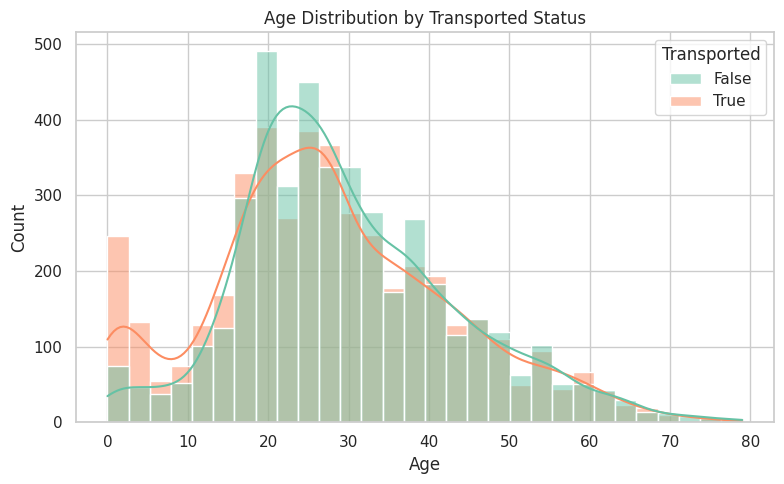

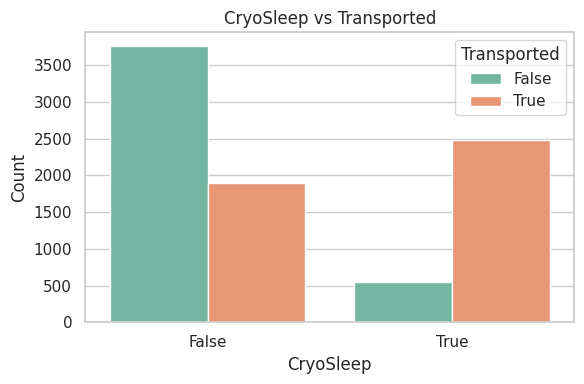

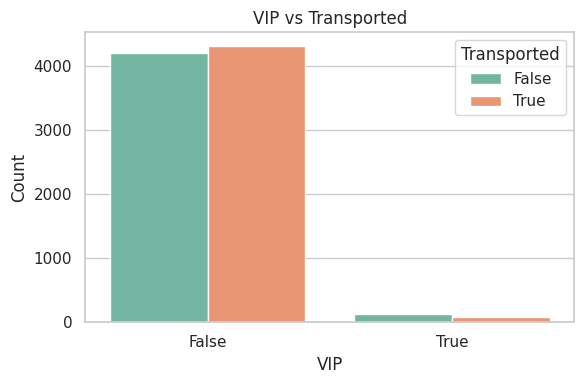

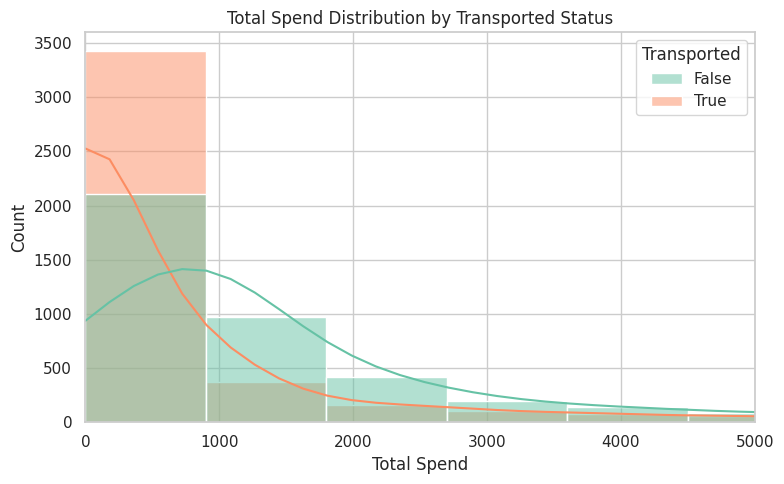

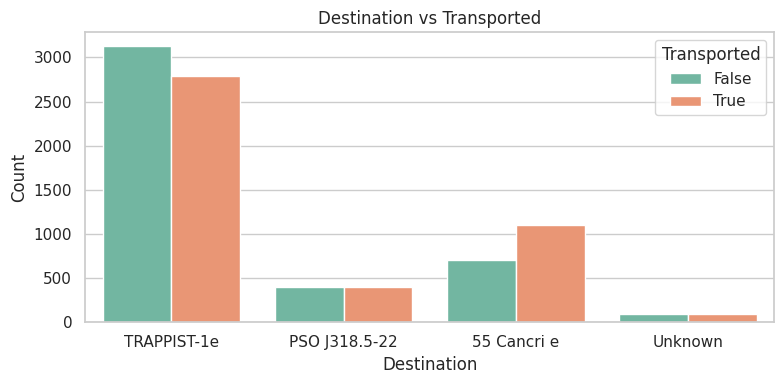

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the dataset for EDA (only use training data)
eda_df = full_df_encoded[full_df_encoded['is_train'] == True].copy()
eda_df['Transported'] = eda_df['Transported'].astype(bool)

# Set Seaborn style
sns.set(style="whitegrid")

# Create Age distribution plot by Transported
plt.figure(figsize=(8, 5))
sns.histplot(data=eda_df, x='Age', hue='Transported', bins=30, kde=True, palette='Set2')
plt.title('Age Distribution by Transported Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# CryoSleep vs Transported
plt.figure(figsize=(6, 4))
sns.countplot(data=eda_df, x='CryoSleep', hue='Transported', palette='Set2')
plt.title('CryoSleep vs Transported')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# VIP vs Transported
plt.figure(figsize=(6, 4))
sns.countplot(data=eda_df, x='VIP', hue='Transported', palette='Set2')
plt.title('VIP vs Transported')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Spending (TotalSpend) distribution by Transported
plt.figure(figsize=(8, 5))
sns.histplot(data=eda_df, x='TotalSpend', hue='Transported', bins=40, kde=True, palette='Set2')
plt.title('Total Spend Distribution by Transported Status')
plt.xlabel('Total Spend')
plt.xlim(0, 5000)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Destination breakdown vs Transported
plt.figure(figsize=(8, 4))
sns.countplot(data=full_df[full_df['is_train'] == True], x='Destination', hue='Transported', palette='Set2')
plt.title('Destination vs Transported')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


**Step 4**: In this step, we trained a baseline Random Forest classifier using default parameters to evaluate initial model performance. The training dataset was split into training and validation sets (80/20 split), with features excluding the passenger ID and target column. After training the model, we predicted outcomes on the validation set and evaluated its performance using several classification metrics, including accuracy, precision, recall, and F1 score. We also generated a confusion matrix and a full classification report to assess class-wise performance. These metrics served as a benchmark to guide further model tuning.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Separate train and test from combined data
train_df = full_df_encoded[full_df_encoded['is_train'] == True].drop(columns=['is_train'])
test_df = full_df_encoded[full_df_encoded['is_train'] == False].drop(columns=['is_train', 'Transported'])

# Define features and target
X = train_df.drop(columns=['PassengerId', 'Transported'])
y = train_df['Transported'].astype(bool)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# Compute evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

# Display metrics
print("Validation Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Validation Accuracy: 0.7935595169637722
Precision: 0.8122743682310469
Recall: 0.7687927107061503
F1 Score: 0.7899356348741955

Confusion Matrix:
 [[705 156]
 [203 675]]

Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.82      0.80       861
        True       0.81      0.77      0.79       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



**Step 5**: To better visualize how well the baseline model performed, we plotted the confusion matrix using Seaborn's heatmap. This plot clearly shows the number of true positives, true negatives, false positives, and false negatives. It allows us to assess the model's strengths and weaknesses, especially in distinguishing between passengers who were transported and those who were not. A well-balanced matrix, with higher values along the diagonal, indicates better classification performance.


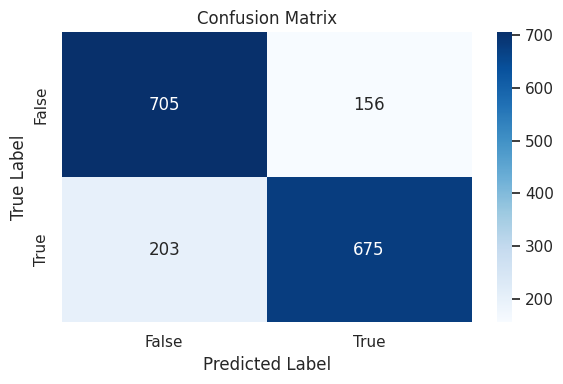

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


**Step 6**: After validating the model, we used it to make predictions on the test dataset. We applied the same feature set used in training (excluding PassengerId) and generated predictions using our trained Random Forest model. The predictions were compiled into a submission DataFrame containing PassengerId and the predicted Transported status (converted to Boolean format). Finally, the results were saved to a CSV file named submission.csv, ready for upload to the Kaggle competition platform.

In [9]:

# Use the same features as training
X_test = test_df.drop(columns=['PassengerId'])

# Predict on test set
test_preds = model.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': test_preds
})

# Convert predictions to boolean
submission['Transported'] = submission['Transported'].astype(bool)

# Save to CSV
submission.to_csv("submission.csv", index=False)

# Show preview
submission.head()

,PassengerId,Transported
8693,0013_01,True
8694,0018_01,False
8695,0019_01,True
8696,0021_01,True
8697,0023_01,True


In [16]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Step 7**: To enhance the baseline model, we applied GridSearchCV for hyperparameter tuning on the Random Forest classifier. A parameter grid was defined to search across various values of n_estimators, max_depth, min_samples_split, min_samples_leaf, and max_features. GridSearchCV performed 3-fold cross-validation over all parameter combinations to identify the best-performing configuration. The best model was then evaluated on the validation set using standard metrics (accuracy, precision, recall, F1 score), and its performance was visualized using a confusion matrix. The tuned model achieved slightly better performance compared to the baseline, especially in recall and F1 score, indicating more balanced predictions.

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Tuned Validation Accuracy: 0.7947096032202415
Precision: 0.8053927315357562
Recall: 0.7824601366742597
F1 Score: 0.7937608318890814

Confusion Matrix:
 [[695 166]
 [191 687]]

Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.81      0.80       861
        True       0.81      0.78      0.79       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.80      0.79      0.79      1739



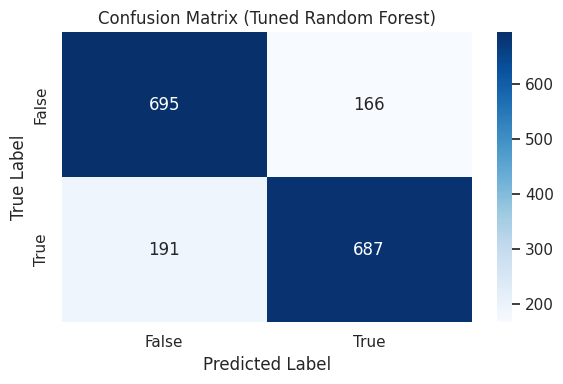

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Best estimator
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict on validation set
y_val_pred = best_rf.predict(X_val)

# Metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)
class_report = classification_report(y_val, y_val_pred)

# Print metrics
print(f"Tuned Validation Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Tuned Random Forest)')
plt.tight_layout()
plt.show()


**Step 8**: Using the best-performing model obtained from GridSearchCV, we generated predictions on the test dataset. We used the same feature set as during training and excluded the PassengerId column from the input. The predictions were converted to Boolean format to match the competition requirements. The output was compiled into a DataFrame (PassengerId, Transported) for review, with the first few rows displayed as a preview. This output can be used to create the final Kaggle submission.

In [12]:
# Use the same features as training
X_test = test_df.drop(columns=['PassengerId'])

# Predict using the best tuned model
test_preds = best_rf.predict(X_test)

# Preview predictions as a DataFrame
tuned_prediction_output = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': test_preds.astype(bool)
})

# Show first few predictions
tuned_prediction_output.head()

,PassengerId,Transported
8693,0013_01,True
8694,0018_01,False
8695,0019_01,True
8696,0021_01,True
8697,0023_01,False


In [13]:
# Reassign if needed
feature_names = X_train.columns.tolist()


In [14]:
print("Feature count:", len(feature_names))
print("Importances count:", len(best_rf.feature_importances_))


Feature count: 26
Importances count: 26


Step 9:To understand which features contributed most to the model's predictions, we extracted and visualized feature importances from the tuned Random Forest classifier. The model was re-fitted on the training data to ensure consistency. Using the .feature_importances_ attribute, we ranked features based on their predictive power. The top 15 features were plotted using a horizontal bar chart, highlighting that variables like TotalSpend, Age, and service usage features (e.g., Spa, VRDeck) played a significant role in determining transport status. This visualization supports model interpretability and helps identify which attributes most influence outcomes.



/tmp/ipython-input-2916803825.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


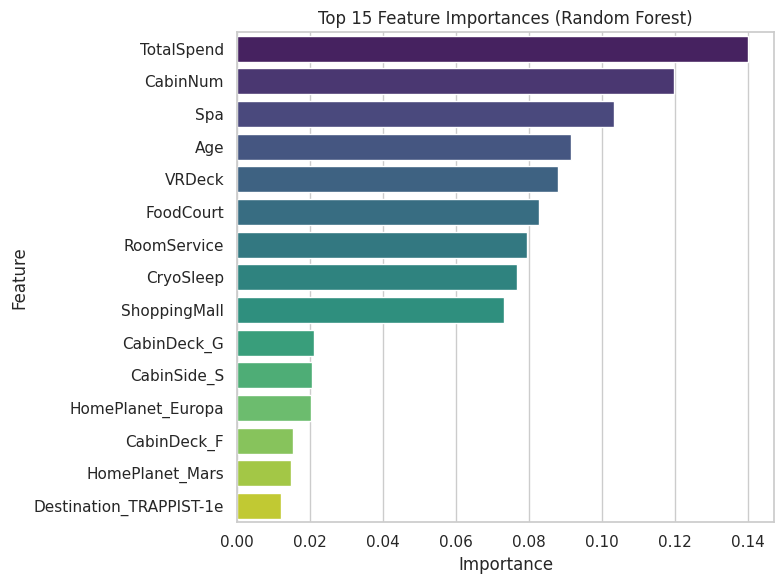

In [15]:
# Recreate the exact input used for fitting, just to align dimensions
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine X_train and y_train for sanity
df_model_input = X_train.copy()
df_model_input['Transported'] = y_train

# Fit model again on X_train to be safe
from sklearn.ensemble import RandomForestClassifier
model_check = RandomForestClassifier(**best_rf.get_params())
model_check.fit(X_train, y_train)

# Now use X_train.columns with correct order
feature_names = X_train.columns.tolist()
importances = model_check.feature_importances_

# Create and plot
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()
